# Project 4. Wrangle and Analyze Data 

## Data wrangling
### - Gathering data

* 1 I have downloaded the file **twitter_archive_enhanced.csv** manually in workspaces.

* 2 Programmatic download using the library **Request**

In [2]:
import requests
import os

In [3]:
folder_name = 'predictions_dogs'

In [4]:
# Make directory if it doesn't already exist
folder_name = 'predictions_dogs'
if not os.path.exists(folder_name):
    os.makedirs(folder_name,mode=511)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [5]:
with open (os.path.join(folder_name,url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

**TESTING:**

In [6]:
print (os.listdir(folder_name))

['image-predictions.tsv']


* 3 Each tweet's **retweet count and favorite ("like")** count at minimum, and any additional data you find interesting

In [7]:
import tweepy
import numpy as np
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import pandas as pd
import time
import regex as re

In [8]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'dM5q4kIqwTEoQzOsXpNS4DceY'
consumer_secret = 'vv8pTvVcxJmFvPqDMdAr4za5HXZKUx6X7yDawArkUpNN1lCQs8'
access_token = '1108105912508657664-bVjVh0DrVy2kzKFX2rHcwSabVFzCaz'
access_secret = '0eE6XN86dRE2Fii7mNZoPYPO2RjQKQFJOXPURHVaVRZbZ'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [9]:
# Get the User object for @dog_rates...
user = api.get_user('@dog_rates')

print (user.followers_count)
for friend in user.friends():
   print (friend.screen_name)

7887103
ChronicleBooks
IvePetThatDog
TheVFoundation
FixYourBiz
hess_clint
Summersdale
AndrewsMcMeel
skyhorsepub
dog_feelings
unwise
mackemode
dogfather


In [10]:
df_1 = pd.read_csv('twitter_archive_enhanced.csv')
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

2356

**NOTE:** I charge 'tweet-json.txt' for the Fails and the little time I have

**DataFrame with (at minimum) tweet ID, retweet count, and favorite count**

In [11]:
df = pd.read_json('tweet_json.txt', lines=True)

In [12]:
#read photos dogs
photo_dogs = pd.read_table('predictions_dogs/image-predictions.tsv', sep='\t')

In [13]:
print ('Tweets:',df['id'].count())
print ('Retweets:',df['retweet_count'].sum())
print ('Favorites:', df['favorited'].value_counts())
print ('Sum favorite_count:', df['favorite_count'].sum())

Tweets: 2354
Retweets: 7449933
Favorites: False    2346
True        8
Name: favorited, dtype: int64
Sum favorite_count: 19022600


### - Assessing data
#### **Evaluating data for this project**
After collecting each of the above data, evaluate them visually and programmatically to detect problems of quality and order. Detect and document at least eight (8) quality problems and two (2) cleaning problems on your wrangle_act.ipynbupport Jupyter. To meet the specifications, problems that satisfy the motivation of the project must be evaluated (see the heading Key points on the previous page).
#### eight (8) quality issues
- **contributors, coordinates and geo** They have 0 data. Those columns are eliminated as unnecessary.
- **created_at** it does not have to be on datetime64. Create 3 columns with the year, month and day.
- Line breaks in **full_text**. Remove.
- Aislar el nombre del perro de **full_text**. 
- Extract the url from **full_text** in another column.
- Extract the vote **full_text** in another column.
- **place** has only one record. You can ignore and delete column.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [15]:
photo_dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
df['text_split'] = df['full_text'].str.split()

In [17]:
names = []

def extract_names(row):
    # name           
    if 'named' in row['full_text'] and re.match(r'[A-Z].*', row['text_split'][(row['text_split'].index('named') + 1)]): 
            names.append(row['text_split'][(row['text_split'].index('named') + 1)])
    # Here we have 
    elif row['full_text'].startswith('Here we have ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    # This is 
    elif row['full_text'].startswith('This is ') and re.match(r'[A-Z].*', row['text_split'][2]):
            names.append(row['text_split'][2].strip('.').strip(','))
    # Say hello to
    elif row['full_text'].startswith('Say hello to ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    # Meet 
    elif row['full_text'].startswith('Meet ') and re.match(r'[A-Z].*', row['text_split'][1]):
            names.append(row['text_split'][1].strip('.').strip(','))
    else:
        names.append('withoutname')
        
df.apply(extract_names, axis=1)
df['dog_names'] = names

In [18]:
df.drop(['text_split'], axis='columns', inplace = True)
print (df.dog_names.head())
print (df.dog_names.value_counts().head())

0     Phineas
1       Tilly
2      Archie
3       Darla
4    Franklin
Name: dog_names, dtype: object
withoutname    943
Lucy            11
Charlie         11
Oliver          10
Cooper          10
Name: dog_names, dtype: int64


#### Cleaning Data and tidiness issues
#### **Cleaning data for this project**
Clean each of the problems you documented when evaluating. Perform this wrangle_act.ipynb cleaning as well. The result should be a high-quality and ordered Master DataFrame of pandas (or DataFrames, if applicable). Again, the problems that satisfy the Project Motivation must be cleared.

In [19]:
# Copy the dataframes 
df_clean = df_1.copy()
photo_dogs_clean = photo_dogs.copy()
df_tweet_clean = df.copy()

- Clearing data from **df_tweet_clean**

In [20]:
# renombro 'id' para igualarlo con los otros df y lo cambio a str
df_tweet_clean.rename(columns={'id': 'tweet_id'}, inplace=True)
df_tweet_clean.tweet_id = df_tweet_clean.tweet_id.astype(str)

In [21]:
# I eliminate retweets
df_tweet_clean.drop(df_tweet_clean[df_tweet_clean['retweeted_status'].notnull()== True].index,inplace=True)

In [22]:
# I delete columns that we do not use, I create year, month and day and I eliminate page breaks in 'full_text'
df_tweet_clean['year'] = df_tweet_clean['created_at'].dt.year
df_tweet_clean['month'] = df_tweet_clean['created_at'].dt.month
df_tweet_clean['day'] = df_tweet_clean['created_at'].dt.day
df_tweet_clean.drop(['contributors',
                     'coordinates',
                     'created_at',
                     'entities',
                     'extended_entities',
                     'favorited',
                     'geo',
                     'id_str',
                     'in_reply_to_screen_name',
                     'in_reply_to_status_id',
                     'in_reply_to_status_id_str',
                     'in_reply_to_user_id',
                     'in_reply_to_user_id_str',
                     'is_quote_status',
                     'lang',
                     'place',
                     'possibly_sensitive',
                     'possibly_sensitive_appealable',
                     'quoted_status',
                     'quoted_status_id',
                     'quoted_status_id_str',
                     'retweeted',
                     'retweeted_status',
                     'source',
                     'truncated',
                     'user'], axis=1,inplace=True)
df_tweet_clean.full_text.replace('\n', ' ')
df_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2353
Data columns (total 9 columns):
display_text_range    2175 non-null object
favorite_count        2175 non-null int64
full_text             2175 non-null object
tweet_id              2175 non-null object
retweet_count         2175 non-null int64
dog_names             2175 non-null object
year                  2175 non-null int64
month                 2175 non-null int64
day                   2175 non-null int64
dtypes: int64(5), object(4)
memory usage: 169.9+ KB


- Clearing data from **photo_dogs_clean**

In [23]:
photo_dogs_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1756,825026590719483904,https://pbs.twimg.com/media/C3MVTeHWcAAGNfx.jpg,2,Eskimo_dog,0.524454,True,Siberian_husky,0.467678,True,malamute,4.975840e-03,True
1760,825876512159186944,https://pbs.twimg.com/media/C3YaSnQWAAILgz0.jpg,1,shopping_cart,0.995941,False,shopping_basket,0.004057,False,mousetrap,8.832830e-07,False
1299,752519690950500352,https://pbs.twimg.com/media/CnF8qVDWYAAh0g1.jpg,3,swing,0.999984,False,Labrador_retriever,0.000010,True,Eskimo_dog,1.434470e-06,True
944,704364645503647744,https://pbs.twimg.com/media/CcZn6RWWIAAmOZG.jpg,1,Pembroke,0.980695,True,Cardigan,0.018504,True,Chihuahua,2.152930e-04,True
940,703774238772166656,https://pbs.twimg.com/media/CcRO8FmW4AAzazk.jpg,1,Labrador_retriever,0.990119,True,Chesapeake_Bay_retriever,0.008026,True,curly-coated_retriever,1.242290e-03,True


In [24]:
# change '_' por ' '
photo_dogs_clean['p1'] = photo_dogs_clean['p1'].str.replace('_', ' ')
photo_dogs_clean['p2'] = photo_dogs_clean['p2'].str.replace('_', ' ')
photo_dogs_clean['p3'] = photo_dogs_clean['p3'].str.replace('_', ' ')
photo_dogs_clean['p1'] = photo_dogs_clean['p1'].str.title()
photo_dogs_clean['p2'] = photo_dogs_clean['p2'].str.title()
photo_dogs_clean['p3'] = photo_dogs_clean['p3'].str.title()

In [25]:
# Change tweet_id to object to match it with the other df
photo_dogs_clean.tweet_id = photo_dogs_clean.tweet_id.astype(str)
photo_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


- Clearing data from **df_clean**

In [28]:
# I delete the records with data in 'retweeted_status id'
df_clean.drop(df_clean[df_clean['retweeted_status_id'].notnull()== True].index,inplace=True)

In [29]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [30]:
# Missing Data
# change by its correct name or none
df_clean['name'].replace('the', 'None', inplace=True)
df_clean['name'].replace("light",'None', inplace=True)
df_clean['name'].replace("life",'None', inplace=True)
df_clean['name'].replace("an",'None', inplace=True)
df_clean['name'].replace("a",'None', inplace=True)
df_clean['name'].replace("by",'None', inplace=True)
df_clean['name'].replace("actually",'None', inplace=True)
df_clean['name'].replace("just",'None', inplace=True)
df_clean['name'].replace("getting",'None', inplace=True) 
df_clean['name'].replace("infuriating",'None', inplace=True) 
df_clean['name'].replace("old",'None', inplace=True) 
df_clean['name'].replace("all",'None', inplace=True) 
df_clean['name'].replace("this",'None', inplace=True) 
df_clean['name'].replace("very",'None', inplace=True) 
df_clean['name'].replace("mad",'None', inplace=True) 
df_clean['name'].replace("not",'None', inplace=True)
df_clean['name'].replace("one",'None', inplace=True)
df_clean['name'].replace("my",'None', inplace=True)
df_clean['name'].replace("O","O'Malley", inplace=True)
df_clean['name'].replace("quite","None", inplace=True)
df_clean['name'].replace("such","None", inplace=True)

In [31]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [32]:
# remove these values from the dataframe using the drop() function
df_clean.drop(df_clean[df_clean['retweeted_status_id'].notnull()== True].index,inplace=True)

In [33]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [34]:
# Separate the 'stage' of each dog in a new column
df_clean['stage'] = df_clean[['doggo','floofer','pupper','puppo']].apply(lambda x: ''.join(x), axis=1)

df_clean['stage'].replace("NoneNoneNoneNone","None ", inplace=True)
df_clean['stage'].replace("doggoNoneNoneNone","doggo", inplace=True)
df_clean['stage'].replace("NoneflooferNoneNone","floofer", inplace=True)
df_clean['stage'].replace("NoneNonepupperNone","pupper", inplace=True)
df_clean['stage'].replace("NoneNoneNonepuppo","puppo", inplace=True)

In [35]:
df_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
467,817120970343411712,NaN,NaN,2017-01-05 21:29:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Name a more iconic quartet... I'll wait. 13/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817120970...,13,10,None,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None,None
1201,716447146686459905,NaN,NaN,2016-04-03 02:08:05 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Ozzy. He's acrobatic af. Legendary pup...,NaN,NaN,NaN,https://vine.co/v/eMmXVPn5eQK,13,10,Ozzy,None,None,pupper,None,pupper
1524,690597161306841088,NaN,NaN,2016-01-22 18:09:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lolo. She's America af. Behind in scie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690597161...,11,10,Lolo,None,None,None,None,None


In [36]:
# create year, month and day
from datetime import datetime,timedelta
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['year'] = df_clean['timestamp'].dt.year
df_clean['month'] = df_clean['timestamp'].dt.month
df_clean['day'] = df_clean['timestamp'].dt.day

In [37]:
# delete columns that are not going to be used
df_clean.drop(['retweeted_status_user_id',
               'retweeted_status_id',
               'retweeted_status_timestamp',
               'in_reply_to_status_id',
               'in_reply_to_user_id',
               'in_reply_to_status_id',
               'expanded_urls',
               'source',
               'doggo',
               'floofer',
               'pupper',
               'puppo',
               'text'], axis=1,inplace=True)

In [38]:
df_clean.sample(5)

,tweet_id,timestamp,rating_numerator,rating_denominator,name,stage,year,month,day
117,870063196459192321,2017-05-31 23:43:25,14,10,Clifford,None,2017,5,31
376,828046555563323392,2017-02-05 01:04:17,13,10,Sailer,None,2017,2,5
1244,711743778164514816,2016-03-21 02:38:34,11,10,Roosevelt,None,2016,3,21
396,825147591692263424,2017-01-28 01:04:51,13,10,Sweet,None,2017,1,28
560,802952499103731712,2016-11-27 19:09:28,12,10,Marley,None,2016,11,27


In [39]:
# The data type is changed to object
df_clean.tweet_id = df_clean.tweet_id.astype(str)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
stage                 2175 non-null object
year                  2175 non-null int64
month                 2175 non-null int64
day                   2175 non-null int64
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 169.9+ KB


#### MERGES 

In [40]:
df_merge = pd.merge(df_clean, df_tweet_clean,on='tweet_id', how='inner')

In [41]:
df_merge = pd.merge(df_merge, photo_dogs_clean,on='tweet_id', how='inner')

In [42]:
df_merge

,tweet_id,timestamp,rating_numerator,rating_denominator,name,stage,year_x,month_x,day_x,display_text_range,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,13,10,Phineas,None,2017,8,1,"[0, 85]",...,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,13,10,Tilly,None,2017,8,1,"[0, 138]",...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,12,10,Archie,None,2017,7,31,"[0, 121]",...,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,13,10,Darla,None,2017,7,30,"[0, 79]",...,1,Paper Towel,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,12,10,Franklin,None,2017,7,29,"[0, 138]",...,2,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True
5,891087950875897856,2017-07-29 00:08:17,13,10,None,None,2017,7,29,"[0, 138]",...,1,Chesapeake Bay Retriever,0.425595,True,Irish Terrier,0.116317,True,Indian Elephant,0.076902,False
6,890971913173991426,2017-07-28 16:27:12,13,10,Jax,None,2017,7,28,"[0, 140]",...,1,Appenzeller,0.341703,True,Border Collie,0.199287,True,Ice Lolly,0.193548,False
7,890729181411237888,2017-07-28 00:22:40,13,10,None,None,2017,7,28,"[0, 118]",...,2,Pomeranian,0.566142,True,Eskimo Dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,2017-07-27 16:25:51,13,10,Zoey,None,2017,7,27,"[0, 122]",...,1,Irish Terrier,0.487574,True,Irish Setter,0.193054,True,Chesapeake Bay Retriever,0.118184,True
9,890240255349198849,2017-07-26 15:59:51,14,10,Cassie,doggo,2017,7,26,"[0, 133]",...,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


#### **Storage, analysis and visualization of data for this project**
Store the clean DataFrames in a CSV file with the main name twitter_archive_master.csv. If additional files exist because several tables are required for sorting, name these files appropriately. In addition, you can store the cleaned data in an SQLite database (which will also be sent if you do).

Analyze and visualize your unordered data in your wrangle_act.ipynb Jupyter notebook. At least three (3) ideas and one (1) visualization must be produced.

#### Store the Cleaned dataframes

In [196]:
# Save to a file
folder_name = 'definitivo'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
df_clean.to_csv('definitivo/twitter_master.csv')
photo_dogs_clean.to_csv('definitivo/photo_dogs_master.csv')
df_tweet_clean.to_csv('definitivo/tweet_query_master.csv')
df_merge.to_csv('definitivo/definitivo_master.csv')

#### Analisys

#### Visualizations

In [199]:
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NameError: name 'plt' is not defined

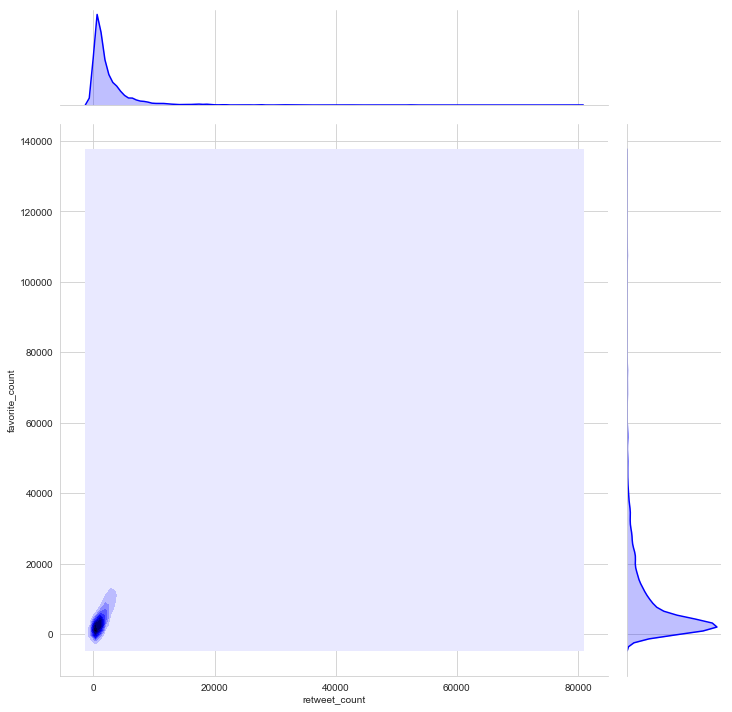

In [201]:
####################
###### CAMBIAR #####
####################

#Visualization comparing the favorite & retweet counts
sns.set_style('whitegrid')
g = sns.jointplot(x="retweet_count", 
                  y="favorite_count", 
                  data=df_merge, 
                  color="blue",
                  kind="kde", 
                  size=10)
g.plot_joint(plt.scatter,  
             c="black",
             s=80, 
             linewidth=1, 
             marker="+",
             alpha=0.45)
g.set_axis_labels("Retweet Count", "Favorite Count",fontsize=12)

g.fig.subplots_adjust(top=0.9)
sns.plt.suptitle('Is there a correlation between the retweet & favorite counts?',
                 fontsize=16)

#### **Reporting for this project**
Create a written 300-600 word report called wrangle_report.pdfo wrangle_report.html that briefly describes your discussion efforts. This must be framed as an internal document.

Create a ** written report with a minimum of 250 words ** called act_report.pdf or act_report.html that communicates the knowledge and shows the visualizations produced from your ordered data. This should be framed as an external document, such as a blog post or a magazine article, for example.